Número de genes en el dataset: 32285
Número de células filtradas: 2815
Genes encontrados en el dataset: ['Cyp19a1', 'Cspg4', 'Pvalb']
Número total de genes en el dataset: 32285
loading file: Zeng-Aging-Mouse-10Xv3
 - time taken:  282.5625
total time taken: 282.5625
	total cells: 2815 processed cells: 2815
Forma de los datos de expresión génica: (2815, 32285)
Células válidas en los datos de expresión: 2815
                              cell_barcode  gene_count  umi_count  \
cell_label                                                          
AAATGGAAGGTAAAGG-419_A05  AAATGGAAGGTAAAGG        5644    19574.0   
AAATGGATCCCTGGTT-419_A05  AAATGGATCCCTGGTT        7203    35895.0   
AACAAGACAAGACGAC-419_A05  AACAAGACAAGACGAC        6299    26844.0   
AACAAGAGTTGATGTC-419_A05  AACAAGAGTTGATGTC        6408    24186.0   
AACGGGATCCAACACA-419_A05  AACGGGATCCAACACA        6570    26982.0   

                          doublet_score          x         y  cluster_alias  \
cell_label                  

C:\Users\Pablo\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Pablo\AppData\Local\Temp\ipykernel_11096\4083778354.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


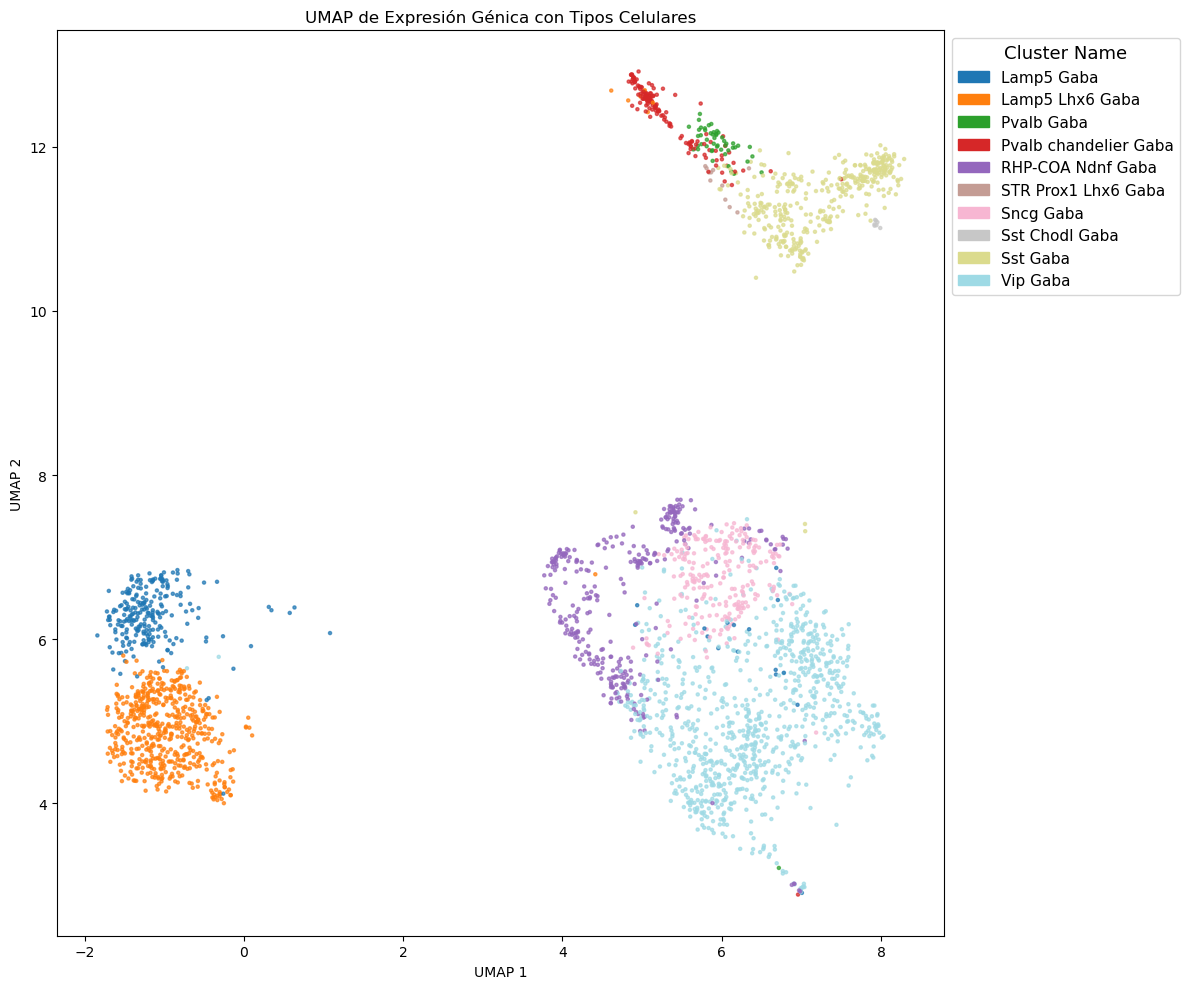

Matriz reducida guardada en G:\Alberto\Transcriptomics\Results\reduced_umap_data.csv


In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import re
from pathlib import Path
import numpy as np
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

# Configurar el directorio y caché
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

# Obtener metadatos de genes
gene = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='gene').set_index('gene_identifier')
print(f"Número de genes en el dataset: {len(gene)}")

# Obtener metadatos de células
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str, 'wmb_cluster_alias': 'Int64'}
)

# Obtener anotaciones de clusters celulares
cell_cluster_annotations = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_cluster_annotations'
)

# Fusionar metadatos celulares con anotaciones de neurotransmisores
merged_cells = pd.merge(
    cell_metadata,
    cell_cluster_annotations[['cell_label', 'neurotransmitter_combined_label', 'cluster_name']],
    on='cell_label',
    how='inner'
)

# Filtrar células por región y neurotransmisor
filtered_cells = merged_cells[
    (merged_cells['region_of_interest_label'] == 'HPF - HIP') &
    (merged_cells['neurotransmitter_combined_label'] == 'GABA')
]
print(f"Número de células filtradas: {len(filtered_cells)}")

# Lista de genes de interés
gene_names = ['Pvalb', 'Cyp19a1', 'Cspg4']
genes_found = gene[gene['gene_symbol'].isin(gene_names)]['gene_symbol'].tolist()
print(f"Genes encontrados en el dataset: {genes_found}")

# Obtener todos los genes del dataset
all_gene_names = gene['gene_symbol'].tolist()
print(f"Número total de genes en el dataset: {len(all_gene_names)}")

# Asegurar que los índices de células coincidan
filtered_cells = filtered_cells.set_index('cell_label')

# Obtener datos de expresión génica
gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=filtered_cells,
    all_genes=gene, 
    selected_genes=all_gene_names, #cambiar a all_gene_names si quieres toda la info genetica o a gene_names si quieres alguno en especial
    data_type="log2"
)

print(f"Forma de los datos de expresión génica: {gene_data.shape}")

# Asegurar que las células en gene_data están en filtered_cells
valid_cells = gene_data.index.intersection(filtered_cells.index)
print(f"Células válidas en los datos de expresión: {len(valid_cells)}")
valid_gene_data = gene_data.loc[valid_cells]

# Fusionar los datos de expresión con las células filtradas
final_cells_with_genes = filtered_cells.merge(valid_gene_data, left_index=True, right_index=True)
print(final_cells_with_genes.head())

# Exportar matriz completa a CSV
output_file = Path(r'G:\Alberto\Transcriptomics\Results\cells_with_genes_allgene.csv')
final_cells_with_genes.to_csv(output_file, index=True)
print(f"Datos exportados a {output_file}")

# Aplicar UMAP
expression_data = final_cells_with_genes[all_gene_names]
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(expression_data)

# Normalizar nombres de cluster
def unify_cluster_name(cluster_name):
    cluster_name = re.sub(r'^\d+_', '', cluster_name)  # Quitar prefijos numéricos
    cluster_name = re.sub(r'_\d+$', '', cluster_name)  # Quitar sufijos numéricos
    return cluster_name

final_cells_with_genes['cluster_name'] = final_cells_with_genes['cluster_name'].apply(unify_cluster_name)

# Convertir clusters a códigos numéricos para el color
cluster_codes = final_cells_with_genes['cluster_name'].astype('category').cat.codes
num_clusters = len(final_cells_with_genes['cluster_name'].unique())
cmap = cm.get_cmap('tab20', num_clusters)

# Crear el scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_codes, cmap=cmap, s=5, alpha=0.7)
plt.title('UMAP de Expresión Génica con Tipos Celulares')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Crear leyenda con colores correctos
cluster_labels = final_cells_with_genes['cluster_name'].astype('category').cat.categories
legend_patches = [mpatches.Patch(color=cmap(i / num_clusters), label=label) for i, label in enumerate(cluster_labels)]
plt.legend(handles=legend_patches, title="Cluster Name", loc="upper left", bbox_to_anchor=(1, 1), title_fontsize='13', fontsize='11')

plt.tight_layout()
plt.show()

# Guardar matriz reducida sin columnas de expresión génica
columns_to_remove = all_gene_names + ['x', 'y','doublet_score']
reduced_data = final_cells_with_genes.drop(columns=columns_to_remove, errors='ignore')
reduced_data['UMAP_1'] = umap_embeddings[:, 0]
reduced_data['UMAP_2'] = umap_embeddings[:, 1]

output_reduced_file = Path(r'G:\Alberto\Transcriptomics\Results\reduced_umap_data.xlsx')
reduced_data.to_excel(output_reduced_file, index=True)
print(f"Matriz reducida guardada en {output_reduced_file}")

